In [142]:
import json
import matplotlib.pyplot as plt
import os 

import time
from IPython.display import clear_output

from math import ceil


%matplotlib inline


In [143]:
SAMPLE_RATE = 44100

In [144]:
################ FILL IN'S HERE ################

# Fetching the offset inforamtion from the Ground Truth Extractor software of Lorin 
# (assuming JSON is already parsed)

################ FILL IN
gte_json_dir = '/Users/miroslavkovalenko/Documents/application_files/PyCharm/Master Thesis/dj-mix-ground-truth-extractor/files-UKF-2018'
gte_json_path = os.path.join(gte_json_dir, 'out_1_part_1.json')
xfade_index = 6
################ END FILL IN


json_data = json.load(open(gte_json_path, 'r'))
# Print list of all crossfades
for idx, cf in enumerate(json_data['xfades']):
    t1_name = str(cf['src_tracks'][0]['path']).lstrip('src_tracks/').rstrip('.wav')
    t2_name = str(cf['src_tracks'][1]['path']).lstrip('src_tracks/').rstrip('.wav')
    if idx == xfade_index:
        print('***SELECTED:')
    print('{}: "{}"    --->    "{}'.format(idx, t1_name, t2_name))

t1_name = str(json_data['xfades'][xfade_index]['src_tracks'][0]['path']).lstrip('src_tracks/').rstrip('.wav')
t2_name = str(json_data['xfades'][xfade_index]['src_tracks'][1]['path']).lstrip('src_tracks/').rstrip('.wav')

0: "Mefjus - Pivot Camo  Krooked Remix Camo  Krooked Remix www.my-free-mp3.net"    --->    "Kove - Tonight www.my-free-mp3.net
1: "Barely Alive  Mad Hed City - Warrior www.my-free-mp3.net"    --->    "Black Sun Empire State of Mind Virus Syndicate - Caterpillar Drumsound  Bassline Smith Remix www.my-free-mp3.net
2: "Black Sun Empire State of Mind Virus Syndicate - Caterpillar Drumsound  Bassline Smith Remix www.my-free-mp3.net"    --->    "Dimension - Techno www.my-free-mp3.net
3: "Muzzy  Flite - Elevate feat. Miss Trouble www.my-free-mp3.net"    --->    "Barely Alive  Mad Hed City - Warrior www.my-free-mp3.net
4: "Fox Stevenson - Bruises www.my-free-mp3.net"    --->    "Muzzy  Flite - Elevate feat. Miss Trouble www.my-free-mp3.net
5: "Dimension - Techno www.my-free-mp3.net"    --->    "Mefjus - Pivot Camo  Krooked Remix Camo  Krooked Remix www.my-free-mp3.net
***SELECTED:
6: "Kove - Tonight www.my-free-mp3.net"    --->    "SHY FX feat. Kate Stewart Mr Williamz - Badboy Business feat. 

In [145]:
# Find the offsets of Track A and B

t1_gte_pred_offset = float(json_data['xfades'][xfade_index]['src_tracks'][0]['offset'])
t2_gte_pred_offset = float(json_data['xfades'][xfade_index]['src_tracks'][1]['offset'])

print('Track 1 predicted offset via GTE: {}'.format(t1_gte_pred_offset))
print('Track 2 predicted offset via GTE: {}'.format(t2_gte_pred_offset))

Track 1 predicted offset via GTE: -1005.0
Track 2 predicted offset via GTE: -1224.0


In [146]:
# Annotate the mix with Len's software

from songcollection import SongCollection
from tracklister import TrackLister
from djcontroller import DjController

import numpy as np

from timestretching import time_stretch_and_pitch_shift

import pyaudio
from essentia.standard import MonoWriter

import csv

In [147]:
################ FILL IN'S HERE ################

################ FILL IN
songs_dir = '/Users/miroslavkovalenko/Documents/project_supporting_material/UGent/Master_Thesis/fase_1/mix_and_songs/UKF_Drum_and_bass_2018' # Contrains /mix/<mix_part_name>.wav
mix_name = songs_dir.split('/')[-1]
annotations_dir = '/Users/miroslavkovalenko/Documents/project_supporting_material/UGent/Master_Thesis/fase_1/annotations'
annotations_path = os.path.join(annotations_dir, 'cf_annotations.csv') # OUTPUT
stretched_songs_dir = os.path.join(songs_dir, 'stretched') # auxiliary OUTPUT
################ END FILL IN

print('Mix name: {}'.format(mix_name))

Mix name: UKF_Drum_and_bass_2018


In [148]:
################ FILL IN'S HERE ################

# Detect mix's BPM

sc_mix = SongCollection()
sc_mix.load_directory(os.path.join(songs_dir,'mix'))

print(str(len(sc_mix.songs)) + ' mix loaded [annotated: ' + str(len(sc_mix.get_annotated())) + ']')

sc_mix.annotate()
print('Done annotating!')
print('Number of annotated mixes {}'.format(str(len(sc_mix.get_annotated()))))
print('Number of unannotated mixes {}\n'.format(str(len(sc_mix.get_unannotated()))))

################ FILL IN
mix_index = 0 # (if mix parts exist)
################ END FILL IN

for idx, mix in enumerate(sc_mix.get_annotated()):
    if idx==mix_index:
        print('SELECTED:')
    print('{}: "{}"'.format(idx, mix.title))

mix = sc_mix.get_annotated()[mix_index]
mix.open()
TEMPO = mix.tempo
print('\nTempo mix: {}'.format(TEMPO))

2 mix loaded [annotated: 2]
Done annotating!
Number of annotated mixes 2
Number of unannotated mixes 0

SELECTED:
0: "mix_part_1"
1: "mix_part_2_1500s"

Tempo mix: 173.9


In [149]:
# Annotate the mix songs

sc = SongCollection()
sc.load_directory(songs_dir)
print(str(len(sc.songs)) + ' songs loaded [annotated: ' + str(len(sc.get_annotated())) + ']')

sc.annotate()
print('Done annotating!')

print('Number of annotated songs ' + str(len(sc.get_annotated())))
print('Number of unannotated songs ' + str(len(sc.get_unannotated())))

21 songs loaded [annotated: 21]
Done annotating!
Number of annotated songs 21
Number of unannotated songs 0


In [150]:
tl = TrackLister(sc)

def find_song(title):
    for song in tl.song_collection.get_annotated():
        if song.title == title:
            return song
    raise 'Song not found'

t1 = find_song(t1_name)
t1.open()
t2 = find_song(t2_name)
t2.open()





In [151]:
# Stretch (only the time values) according to the mix's BPM.

f_t1 = t1.tempo/TEMPO
f_t2 = t2.tempo/TEMPO

t1_beats_str = f_t1*np.array(t1.beats)
t2_beats_str = f_t2*np.array(t2.beats)

t1_downbeats_str = f_t1*np.array(t1.downbeats)
t2_downbeats_str = f_t2*np.array(t2.downbeats)




In [152]:
def find_beat_idx(t1_beats_str, beat_shift_in_s):
    most_probable_beat_idx = -1 # Not defined yet
    error_in_s = float('inf') # Not defined yet
    for beat_idx, beat_in_s in enumerate(t1_beats_str):
        error_in_s_local = abs(beat_shift_in_s - beat_in_s) 
        if error_in_s_local < error_in_s:
            error_in_s = error_in_s_local
            most_probable_beat_idx = beat_idx
    return most_probable_beat_idx, error_in_s

'''
Given track 1, track 2 and the prediction of offset t2 wrt t1 (in s) downbeat_shift_in_s (positive).
Finds the closest downbeat (wrt t1)
Returns index, distance to the closest beat, error (in s) wrt given prediction 
& the corresponding index of the first beat (wrt t1) that corresponds with the first beat of t2.
(To be able to compare with the beat aligning method.)
'''
def find_downbeat_idx(t1_downbeats_str, t1_beats_str, downbeat_shift_in_s, t2_beats_str=None, t2_downbeats_str=None):
    most_probable_downbeat_idx = -1 # Not defined yet
    error_in_s = float('inf') # Not defined yet
    for downbeat_idx, downbeat_in_s in enumerate(t1_downbeats_str):
        error_in_s_local = abs(downbeat_shift_in_s - downbeat_in_s) 
        if error_in_s_local < error_in_s:
            error_in_s = error_in_s_local
            most_probable_downbeat_idx = downbeat_idx
        
    _downbeat_shift_in_beats = np.where(t1_beats_str == t1_downbeats_str[most_probable_downbeat_idx])
    if len(_downbeat_shift_in_beats[0])>0:
        downbeat_shift_in_beats = _downbeat_shift_in_beats[0][0]
    else:
        print('Could not find the corresponding beat.')
        downbeat_shift_in_beats = None
    
    downbeat_shift_in_beats_corr_first_beat = None
    if t2_beats_str is not None and t2_downbeats_str is not None:
        _downbeat_shift_in_beats_corr_first_beat = np.where(t2_beats_str == t2_downbeats_str[0])
        if len(_downbeat_shift_in_beats_corr_first_beat[0])>0 and downbeat_shift_in_beats is not None:
                downbeat_shift_in_beats_corr_first_beat = downbeat_shift_in_beats - _downbeat_shift_in_beats_corr_first_beat[0][0]  # To compare w/ beat-aligned result above.
        else:
            print('Could not find the corresponding beat (2).')
            downbeat_shift_in_beats_corr_first_beat = None
    
    return most_probable_downbeat_idx, downbeat_shift_in_beats, error_in_s, downbeat_shift_in_beats_corr_first_beat


In [153]:
################ FILL IN'S HERE ################

print('WARNING: RUN THIS CELL ONLY ONCE!!!\n'
      'WARNING: IF THIS IS THE FIRST SONG!\n'
      '"old_t2_selected_offset" should be set to None\n\n')

################ FILL IN
set_old_t2_selected_offset_to_none = False # Default: false.
################ END FILL IN

# set the old value with the current value
if set_old_t2_selected_offset_to_none is True:
    old_t2_selected_offset = None
    print('WARNING: "old_t2_selected_offset" is set to None')
else:
    try:
        old_t2_selected_offset = annot_t1_offset_used + annot_offset_B_wrt_A_in_s
        print('"old_t2_selected_offset" is set to the previous value')
    except NameError:
        # If the used variables are not set then there is no old value either.
        old_t2_selected_offset = None
        print('WARNING: "old_t2_selected_offset" is set to None')


"old_t2_selected_offset" should be set to None


"old_t2_selected_offset" is set to the previous value


In [154]:
# Time stretch files

t1.openAudio()
t2.openAudio()
t1_audio_stretched = time_stretch_and_pitch_shift(t1.audio, f_t1)
t2_audio_stretched = time_stretch_and_pitch_shift(t2.audio, f_t2)
print('Audio is time stretched.')

# Save stretched audio files

if not os.path.exists(stretched_songs_dir):
    os.makedirs(stretched_songs_dir)

disk_writer = MonoWriter(filename=os.path.join(stretched_songs_dir,'stretched_'+t1.title+'.wav'), bitrate=320,format='wav')
disk_writer(np.array(t1_audio_stretched,dtype='single'))

disk_writer = MonoWriter(filename=os.path.join(stretched_songs_dir,'stretched_'+t2.title+'.wav'), bitrate=320,format='wav')
disk_writer(np.array(t2_audio_stretched,dtype='single'))

print('Time stretched version is saved of disk.')

# Initialising audio playback

mix.openAudio()

pa = pyaudio.PyAudio()
pa_stream = pa.open(format = pyaudio.paFloat32,
						channels=2,
						rate=44100,
						output=True)

Audio is time stretched.
Time stretched version is saved of disk.


In [156]:
################ FILL IN'S HERE ################

# Align Track A & Track B according to each other

################ FILL IN
t1_manual_pred_offset = None # (negative)
                             # If None, value of the previous cross fade is used. 
                             # Normally only not None if this is the first song of the mix 
                             # (in this case use t1_gte_pred_offset for the GTE prediction) 
# t1_manual_pred_offset = t1_gte_pred_offset

t2_manual_pred_offset = None # Leave None if you want GTE to predict if for you. (negative)
################ END FILL IN


def convert_beat_shift_to_offset_B_wrt_A_in_s(beat_shift, t1_beats_str, t2_beats_str):
    corr_offset_B_wrt_A_in_s = -(t1_beats_str[beat_shift] - t2_beats_str[0]) # (negative)
    return corr_offset_B_wrt_A_in_s

if old_t2_selected_offset is None and t1_manual_pred_offset is None:
    raise Exception('t2_pred_offset_old is None! Please specify t1_manual_pred_offset manually.')

t1_pred_offset = old_t2_selected_offset if t1_manual_pred_offset is None else t1_manual_pred_offset
t2_pred_offset = t2_gte_pred_offset if t2_manual_pred_offset is None else t2_manual_pred_offset

print('Predicted offsets: A: {:.4f} , B: {:.4f}\n\n'.format(t1_pred_offset, t2_pred_offset))

print('Align Track A & Track B according to each other:\n\n')

# Beat aligning
beat_shift_in_s = t1_pred_offset-(t2_pred_offset-t2_beats_str[0])
beat_shift, beat_shift_error_in_s = find_beat_idx(t1_beats_str, beat_shift_in_s)
corr_offset_B_wrt_A_beat_a_in_s = convert_beat_shift_to_offset_B_wrt_A_in_s(beat_shift, t1_beats_str, t2_beats_str) # (negative)
print('\tShift (in beats): {} with error (in s): {:.4f}\n'
      '\tOffset B w/ regard to A (using beats alginment) (in s): {:.4f}\n\n'
      .format(beat_shift,beat_shift_error_in_s, corr_offset_B_wrt_A_beat_a_in_s))

# Downbeat aligning
downbeat_shift_in_s = t1_pred_offset - (t2_pred_offset - t2_downbeats_str[0])
downbeat_shift, downbeat_shift_in_beats, downbeat_shift_error_in_s, downbeat_shift_in_beats_corr_first_beat = find_downbeat_idx(
    t1_downbeats_str, t1_beats_str, downbeat_shift_in_s, t2_beats_str, t2_downbeats_str
)
corr_offset_B_wrt_A_downbeat_a_in_s = -(t1_downbeats_str[downbeat_shift] - t2_downbeats_str[0]) # (negative)

print('\tShift (in downbeats using t1): {} (in beats: {}, corresponding first beat: {}) with error (in s): {:.4f}\n'
      '\tOffset B w/ regard to A (using downbeats alignment) (in s): {:.4f}\n'
      .format(downbeat_shift, downbeat_shift_in_beats, downbeat_shift_in_beats_corr_first_beat, downbeat_shift_error_in_s, corr_offset_B_wrt_A_downbeat_a_in_s))

print('Stretch A: {:.4f} ; Stretch B: {:.4f}\n\n\n'.format(1/f_t1, 1/f_t2))

# Align Track A & Track B according the mix

beat_shift_t1_in_s = -t1_pred_offset+t1_beats_str[0]
beat_shift_t1, beat_shift_t1_error_in_s = find_beat_idx(mix.beats, beat_shift_t1_in_s)
corr_offset_t1_wrt_mix_beat_a_in_s = -(mix.beats[beat_shift_t1] - t1_beats_str[0]) # (negative)

downbeat_shift_t1_in_s = -t1_pred_offset+t1_downbeats_str[0]
downbeat_shift_t1, downbeat_shift_t1_in_beats, downbeat_shift_t1_error_in_s, downbeat_shift_t1_in_beats_corr_first_beat = find_downbeat_idx(
    np.array(mix.downbeats), np.array(mix.beats), downbeat_shift_t1_in_s, t1_beats_str, t1_downbeats_str # NOTICE: comparison with respect to the mix, not t2
)

print('(Aligning track A wrt the mix:)\n\n'
      '\tShift (of track A wrt the mix) (in beats): {}  with error (in s): {:.4f}\n'
      '\tOffset w/ regard to the mix (using beats alignment) (in s): {:.4f}\n\n'
      '\tShift (in downbeats): {} (in beats: {}, corresponding first beat: {}) with error (in s): {:.4f}\n\n'
      .format(beat_shift_t1, beat_shift_t1_error_in_s, corr_offset_t1_wrt_mix_beat_a_in_s, downbeat_shift_t1, downbeat_shift_t1_in_beats, downbeat_shift_t1_in_beats_corr_first_beat, downbeat_shift_t1_error_in_s))

beat_shift_t2_in_s = -t2_pred_offset+t2_beats_str[0]
beat_shift_t2, beat_shift_t2_error_in_s = find_beat_idx(mix.beats, beat_shift_t2_in_s)


corr_offset_t2_wrt_mix_beat_a_in_s = -(mix.beats[beat_shift_t2] - t2_beats_str[0]) # (negative)
downbeat_shift_t2_in_s = -t2_pred_offset+t2_downbeats_str[0]
downbeat_shift_t2, downbeat_shift_t2_in_beats, downbeat_shift_t2_error_in_s, downbeat_shift_t2_in_beats_corr_first_beat = find_downbeat_idx(
    np.array(mix.downbeats), np.array(mix.beats), downbeat_shift_t2_in_s, t2_beats_str, t2_downbeats_str # NOTICE: comparison with respect to the mix, not t2
)
print('(Aligning track B wrt the mix:)\n\n'
      '\tShift (in beats): {} with error (in s): {:.4f}\n'
      '\tOffset w/ regard to the mix (using beats alginment) (in s): {:.4f}\n\n'
      '\tShift (in downbeats): {} (in beats: {}, corresponding first beat: {}) with error (in s): {:.4f}\n\n'
      .format(beat_shift_t2, beat_shift_t2_error_in_s, corr_offset_t2_wrt_mix_beat_a_in_s, downbeat_shift_t2, downbeat_shift_t2_in_beats, downbeat_shift_t2_in_beats_corr_first_beat, downbeat_shift_t2_error_in_s))

print('Offset B w/ regard to A (using mix + beats alginment) (in s): {:.4f}'.format(corr_offset_t2_wrt_mix_beat_a_in_s - corr_offset_t1_wrt_mix_beat_a_in_s)) # (negative)




Predicted offsets: A: -1004.7814 , B: -1224.0000


Align Track A & Track B according to each other:


	Shift (in beats): 635 with error (in s): 0.1282
	Offset B w/ regard to A (using beats alginment) (in s): -219.0904


	Shift (in downbeats using t1): 159 (in beats: 636, corresponding first beat: 635) with error (in s): 0.1282
	Offset B w/ regard to A (using downbeats alignment) (in s): -219.0904

Stretch A: 0.9994 ; Stretch B: 0.9994



(Aligning track A wrt the mix:)

	Shift (of track A wrt the mix) (in beats): 2912  with error (in s): 0.0070
	Offset w/ regard to the mix (using beats alignment) (in s): -1004.7744

	Shift (in downbeats): 728 (in beats: 2912, corresponding first beat: 2912) with error (in s): 0.0070


(Aligning track B wrt the mix:)

	Shift (in beats): 3547 with error (in s): 0.1352
	Offset w/ regard to the mix (using beats alginment) (in s): -1223.8648

	Shift (in downbeats): 887 (in beats: 3548, corresponding first beat: 3547) with error (in s): 0.1353


Offset B w/ 

In [158]:
# Play T1 (LEFT) + mix (RIGHT)

print('Note: this is just to check whether T1 is still aligned with mix.\n'
      'Note: listen to the portion that is close to the crossfade (before) considered.\n'
      '\t(The (GTE predicted) cross-fade bounds are (wrt t1): {})\n'
      'Note: meanwhile you can listen to the song to comfortable with it.'
      .format(np.array(json_data['xfades'][xfade_index]['mix_bounds'])+t1_pred_offset))

Note: this is just to check whether T1 is still aligned with mix.
Note: listen to the portion that is close to the crossfade (before) considered.
	(The (GTE predicted) cross-fade bounds are (wrt t1): [219.21863245 242.21863245])
Note: meanwhile you can listen to the song to comfortable with it.


In [164]:
################ FILL IN'S HERE ################

# Listen to T1 + mix

# Continue to next cell if it sounds aligned with the mix (should be), otherwise change above: t1_manual_pred_offset
# Note: you can use Audacity to analyse the last .wav file to calculate the t1_manual_pred_offset

################ FILL IN
t1_and_mix_fast_forward_in_s = 200 # wrt t1
t1_and_mix_play_length_in_s = 10
################ END FILL IN

_mix_start_to_play_in_s = t1_pred_offset # (negative)
print('Using "t1_pred_offset"...\n'
      '({:0.4f} offset (in s) of A wrt mix)'.format(_mix_start_to_play_in_s))
_mix_start_to_play_in_samples = int(-_mix_start_to_play_in_s * SAMPLE_RATE)
_fast_forward_in_samples = int(t1_and_mix_fast_forward_in_s * SAMPLE_RATE)
_length_to_play_in_samples = int(t1_and_mix_play_length_in_s * SAMPLE_RATE)

t1_and_mix_audio = np.vstack((
    t1_audio_stretched[0 + _fast_forward_in_samples : _fast_forward_in_samples + _length_to_play_in_samples],
    mix.audio[_mix_start_to_play_in_samples + _fast_forward_in_samples : (_mix_start_to_play_in_samples + _fast_forward_in_samples) + _length_to_play_in_samples]
))

if t1_and_mix_audio.dtype != 'float32':
    t1_and_mix_audio = t1_and_mix_audio.astype('float32')    
pa_stream.write(t1_and_mix_audio.flatten(order='F'), num_frames=_length_to_play_in_samples, exception_on_underflow=False)




Using "t1_pred_offset"...
(-1004.7814 offset (in s) of A wrt mix)


In [162]:
################ FILL IN'S HERE ################

# Listen to T2 + mix

# Check whether the predicted offset of T2 (after beat-aligning) is correct.
# Continue if the T2 and mix sounds aligned. If not, shift the value below using: selected_offset_B_wrt_A_in_beat_idx_difference.

################ FILL IN
selected_offset_B_wrt_A_in_beat_idx_difference = +1 # FILL IN. If 0 then the most closest beat is used (using TA and TB aligning).
################ END FILL IN

selected_corr_offset_B_wrt_A_beat_a_in_s = convert_beat_shift_to_offset_B_wrt_A_in_s(beat_shift + selected_offset_B_wrt_A_in_beat_idx_difference, t1_beats_str, t2_beats_str) # (negative)

print('Note: listen to the portion that is close (after) to the crossfade considered.\n'
      '\t(The (GTE predicted) cross-fade bounds are (wrt t2): {})\n'
      'Note: meanwhile you can listen to the song to comfortable with it.'
      .format(np.array(json_data['xfades'][xfade_index]['mix_bounds'])+t1_pred_offset+selected_corr_offset_B_wrt_A_beat_a_in_s))


# Play T2 (LEFT) + mix (RIGHT) !

################ FILL IN
t2_and_mix_fast_forward_in_s = 40 # wrt t2
t2_and_mix_play_length_in_s = 10
################ END FILL IN

_mix_start_to_play_in_s = t1_pred_offset + selected_corr_offset_B_wrt_A_beat_a_in_s # (negative)
print('Using beatmatching A and B (+ offset TA wrt mix)...\n'
      '({:0.4f} offset (in s) of B wrt mix)'.format(_mix_start_to_play_in_s))

_mix_start_to_play_in_samples = int(-_mix_start_to_play_in_s * SAMPLE_RATE)
_fast_forward_in_samples = int(t2_and_mix_fast_forward_in_s * SAMPLE_RATE)
_length_to_play_in_samples = int(t2_and_mix_play_length_in_s * SAMPLE_RATE)

t2_and_mix_audio = np.vstack((
    t2_audio_stretched[0 + _fast_forward_in_samples : _fast_forward_in_samples + _length_to_play_in_samples],
    mix.audio[_mix_start_to_play_in_samples + _fast_forward_in_samples : (_mix_start_to_play_in_samples + _fast_forward_in_samples) + _length_to_play_in_samples]
))

if t2_and_mix_audio.dtype != 'float32':
    t2_and_mix_audio = t2_and_mix_audio.astype('float32')
pa_stream.write(t2_and_mix_audio.flatten(order='F'), num_frames=_length_to_play_in_samples, exception_on_underflow=False)

Note: listen to the portion that is close (after) to the crossfade considered.
	(The (GTE predicted) cross-fade bounds are (wrt t2): [-0.21682729 22.78317271])
Note: meanwhile you can listen to the song to comfortable with it.
Using beatmatching A and B (+ offset TA wrt mix)...
(-1224.2168 offset (in s) of B wrt mix)


In [163]:
################ FILL IN'S HERE ################

# Capturing the results

################ FILL IN
annot_gt_stretch_t1 = None # FILL IN if any
annot_gt_stretch_t2 = None # FILL IN if any

annot_stretch_t1 = 1/f_t1 
annot_stretch_t2 = 1/f_t2

annot_gt_offset_t1 = None # FILL IN if any (negative)
annot_gt_offset_t2 = None # FILL IN if any (negative)
################ END FILL IN

annot_t1_offset_used = t1_pred_offset # (negative) t1 offset used to extract some results

annot_offset_B_wrt_A_in_beat_idx = beat_shift + selected_offset_B_wrt_A_in_beat_idx_difference
annot_offset_B_wrt_A_downbeat_distance = find_downbeat_idx(t1_downbeats_str, t1_beats_str, -selected_corr_offset_B_wrt_A_beat_a_in_s, t2_beats_str, t2_downbeats_str)[3] - annot_offset_B_wrt_A_in_beat_idx # (positive or negative)
annot_offset_B_wrt_A_in_s = selected_corr_offset_B_wrt_A_beat_a_in_s # (negative)

print('ANNOTATION SUMMARY:\n')
print('mix name: "{}"\nmix index: {} (name: "{}")\n\nxfade index: {}'.format(mix_name,mix_index,mix.title,xfade_index))
print('Track A: "{}"\nTrack B: "{}"\n'.format(t1_name,t2_name))

print('Stretch A: {:.4} (GT: {})'.format(annot_stretch_t1,annot_gt_stretch_t1))
print('Stretch B: {:.4} (GT: {})\n'.format(annot_stretch_t2,annot_gt_stretch_t2))

print('Offset B wrt. A (in beat idx): {} (deviates {} to a downbeat) (in s: {:0.4f})'.format(annot_offset_B_wrt_A_in_beat_idx,annot_offset_B_wrt_A_downbeat_distance,annot_offset_B_wrt_A_in_s))
print('\tTrack A & B are downbeat aligned!') if annot_offset_B_wrt_A_downbeat_distance == 0 else None
print('(=> Resulting offset B wrt mix (using t1_pred_offset) {:0.4f})\n'.format(t1_pred_offset+annot_offset_B_wrt_A_in_s))
if annot_gt_offset_t1 or annot_gt_offset_t2:
    print('(Ground truth offset wrt to mix (in s): A: {}, B: {} (=> relative offset (in s): {:0.4f}))'.format(annot_gt_offset_t1,annot_gt_offset_t2,-(annot_gt_offset_t1-annot_gt_offset_t2)))

ANNOTATION SUMMARY:

mix name: "UKF_Drum_and_bass_2018"
mix index: 0 (name: "mix_part_1")

xfade index: 6
Track A: "Kove - Tonight www.my-free-mp3.net"
Track B: "SHY FX feat. Kate Stewart Mr Williamz - Badboy Business feat. Kate Stewart and Mr Williamz www.my-free-mp3.net"

Stretch A: 0.9994 (GT: None)
Stretch B: 0.9994 (GT: None)

Offset B wrt. A (in beat idx): 636 (deviates -1 to a downbeat) (in s: -219.4355)
None
(=> Resulting offset B wrt mix (using t1_pred_offset) -1224.2168)



/Users/miroslavkovalenko/.pyenv/versions/2.7.15/envs/dj-2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in less
/Users/miroslavkovalenko/.pyenv/versions/2.7.15/envs/dj-2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in greater
/Users/miroslavkovalenko/.pyenv/versions/2.7.15/envs/dj-2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in greater




Mix bounds: (1224.3, 1247)

Predicted (in s, wrt mix) start_t2: 1224.3000 , stop_t1: 1236.5302


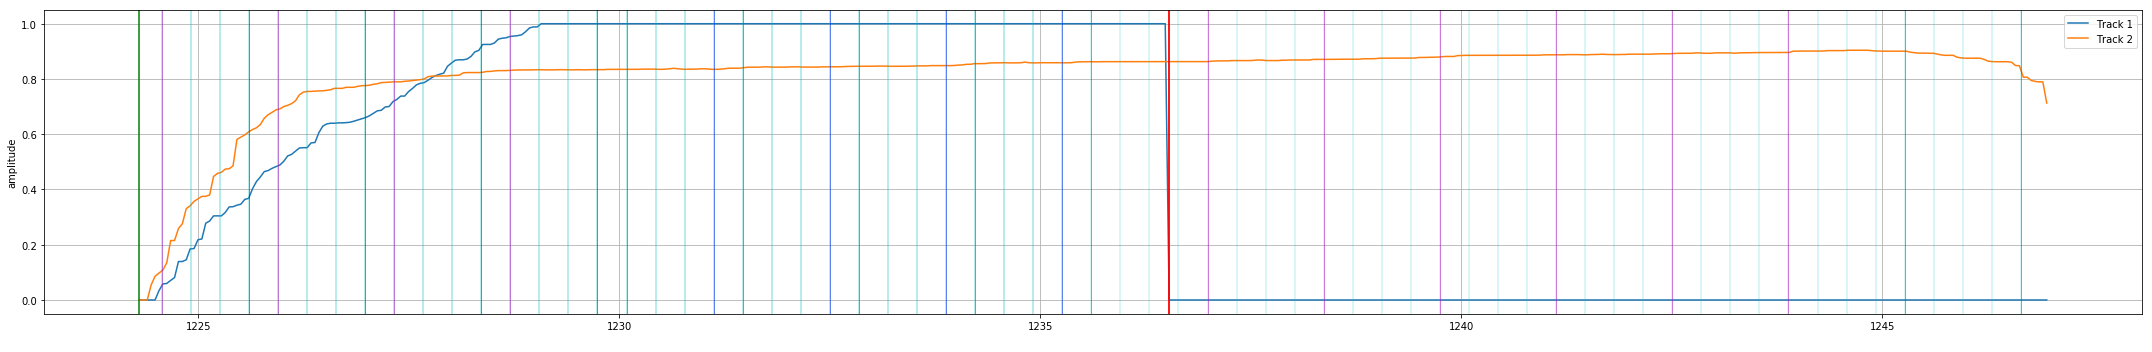

In [166]:
################ FILL IN'S HERE ################

# Analyse the crossfade with 'unmixer.py' and create the graph. This will help to annotate in the next step.


unmix_offset_A_in_s = annot_t1_offset_used # (negative)

################ FILL IN
unmix_mix_bounds = None # FILL IN (leave None if you do want to predict it using GTE)
unmix_mix_bounds = 1224.3, 1247 # FILL IN (leave None if you do want to predict it using GTE)
################ END FILL IN

import dj_mix_ground_truth_extractor.nodes.unmixer
reload(dj_mix_ground_truth_extractor.nodes.unmixer) # Update if the source is changed.
import copy
unmixer = dj_mix_ground_truth_extractor.nodes.unmixer.Unmixer(method='linear',
                                                              prefix_wav_files_path=os.path.join(annotations_dir,'{}--{}--{}--'.format(mix_name,mix_index,xfade_index)))

## Prepare state object
class MatchInfo:
    def __init__(self, path, ident, slope, offset, s):
        self.path = path
        self.ident = ident
        self.bounds = (s[0], s[-1])
        self.slope = slope
        self.offset = offset

    def __str__(self):
        return "{self.path} - {self.ident} - {self.offset}" # (fix if necessery)

if unmix_mix_bounds is None:
    unmix_mix_bounds = json_data['xfades'][xfade_index]['mix_bounds']
else:
    print('WARNING: mix_bounds are user-defined.')
if not unmix_mix_bounds[0] >= -unmix_offset_A_in_s-annot_offset_B_wrt_A_in_s:
    raise Exception('mix_bounds (now: {}) is out of bound for Track B.\n'
                    'Check that: left bound (now: {}) >= {}'.format(unmix_mix_bounds, unmix_mix_bounds[0],-unmix_offset_A_in_s-annot_offset_B_wrt_A_in_s))
state_xfades_mix = tuple(unmix_mix_bounds)
state_xfades_src_tracks_tr1 = MatchInfo(json_data['xfades'][xfade_index]['src_tracks'][0]['path'],
                                        None,
                                        annot_stretch_t1,  # stretch 
                                        unmix_offset_A_in_s,  # offset
                                        [None, None])
state_xfades_src_tracks_tr2 = MatchInfo(json_data['xfades'][xfade_index]['src_tracks'][1]['path'],
                                        None,
                                        annot_stretch_t2,  # stretch 
                                        unmix_offset_A_in_s + annot_offset_B_wrt_A_in_s,  # offset
                                        [None, None])
state_xfades_src_tracks = (state_xfades_src_tracks_tr1, state_xfades_src_tracks_tr2)
state_src_track_paths = songs_dir
state_mix_path = os.path.join(songs_dir,'mix',mix.title+'.wav')


state = {'xfades': [{'mix':state_xfades_mix, 'src_tracks':state_xfades_src_tracks}],
         'src_track_paths':state_src_track_paths,
         'mix_path':state_mix_path}

faders = unmixer.process(state)

## Visualise the result

import matplotlib.pyplot as plt

%matplotlib inline

unmix_t1 = faders['faders'][0][0]
unmix_t2 = faders['faders'][0][1]

unmix_bound_left = unmix_mix_bounds[0]
unmix_bound_right = unmix_mix_bounds[1]
if len(unmix_t1) != len(unmix_t2):
    raise '1'
unmix_duration_xfade = len(unmix_t1)
unmix_x = np.arange(unmix_bound_left,
              unmix_bound_right,
              (unmix_bound_right-unmix_bound_left)/float(unmix_duration_xfade))


if len(unmix_x) != len(unmix_t1):
    print('Error')
    unmix_t1 += [0]
    unmix_t2 += [0]
    print(len(unmix_x))
    print(len(unmix_t1))
    print(len(unmix_t2))

def plot_xfade_profile(x, t1, t2, start_t2=None, stop_t1=None, t1_beats_wrt_mix_in_s=None, t1_downbeats_wrt_mix_in_s=None, t2_beats_wrt_mix_in_s=None, t2_downbeats_wrt_mix_in_s=None):
    fig, ax = plt.subplots(facecolor='white',figsize=(30,5))
    
    ax.plot(x, t1, label='Track 1')
    ax.plot(x, t2, label='Track 2')
    
    if start_t2 is not None and stop_t1 is not None:
        ax.axvline(x=x[start_t2], color='g', linewidth=1.5)
        ax.axvline(x=x[stop_t1], color='r', linewidth=1.8)
    
    if t1_beats_wrt_mix_in_s is not None and t1_downbeats_wrt_mix_in_s is not None:
        for beat in t1_beats_wrt_mix_in_s:
            if beat >= x[0] and beat <= x[-1]:
                ax.axvline(x=beat, color='c', linewidth=.3)
        for downbeat in t1_downbeats_wrt_mix_in_s:
            if downbeat >= x[0] and downbeat <= x[-1]:
                ax.axvline(x=downbeat, color='b', linewidth=.5)
    
    if t2_beats_wrt_mix_in_s is not None and t2_downbeats_wrt_mix_in_s is not None:
        for beat in t2_beats_wrt_mix_in_s:
            if beat >= x[0] and beat <= x[-1]:
                ax.axvline(x=beat, color='c', linewidth=.3)
        for downbeat in t2_downbeats_wrt_mix_in_s:
            if downbeat >= x[0] and downbeat <= x[-1]:
                ax.axvline(x=downbeat, color='m', linewidth=.5)

    ax.legend()
    ax.set_xlabel('time (s)', color='white')
    ax.set_ylabel('amplitude')
    ax.grid(True)
    
    fig.set_tight_layout(True)
    fig.show()
    fig.savefig(os.path.join(annotations_dir,'{}--{}--{}--{}--{}.png'.format(mix_name,mix_index,xfade_index,t1_name,t2_name)))
    
    
# plot_xfade_profile(unmix_x, unmix_t1, unmix_t2)

## Estimate the crossfade's parameters

unmix_t1_ = np.array(unmix_t1)

unmix_sr = (unmix_bound_right-unmix_bound_left)/float(unmix_duration_xfade)  # seconds/point

def sample_to_time(sample_index):  # This is approximately as x[sample_index].
    # time = sample_index*unmix_sr
    # abs_time = bound_left + time
    time = x[sample_index]
    return time

def time_to_sample(time_seconds):
    sample_index = int(round(1 / float(unmix_sr) * time_seconds))
    return sample_index

def trim_marge(t_,marge_seconds):
    marge = time_to_sample(marge_seconds)
    t_[:marge] = None
    t_[len(t_) - marge:] = None
    
def trim_left(t_, marge_sample):
    t_[:marge_sample] = None

unmix_marge_seconds = 5
trim_marge(unmix_t1_, unmix_marge_seconds)

def calc_stop_t1(t1_, from_sample=None):
    stop_t1_bound = .3

    if from_sample is not None:
        t1_trimmed = np.copy(t1_)
        trim_left(t1_trimmed, from_sample)
    else:
        t1_trimmed = t1_
    
    pot_stop_t1 = (t1_trimmed < stop_t1_bound).argmax()
    
    average_length_seconds = 5
    avg_after_pot_stop_t1 = np.average(t1_trimmed[pot_stop_t1:pot_stop_t1 + time_to_sample(average_length_seconds)])
    
    steepness_walking_inhibitor = .001
    average_length_seconds_steepness = 1
    avg_after_pot_stop_t1_steepness = np.average(t1_trimmed[pot_stop_t1:pot_stop_t1 + time_to_sample(average_length_seconds_steepness)])
    
    if avg_after_pot_stop_t1 >= stop_t1_bound:
        print('INFO: avg_after_pot_stop_t1 >= stop_t1_bound: {avg_after_pot_stop_t1} >= {stop_t1_bound}')
        return calc_stop_t1(t1_trimmed, pot_stop_t1 + 1)
    elif t1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor:
        print('INFO: 1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness > steepness_walking_inhibitor: {t1_trimmed[pot_stop_t1] - avg_after_pot_stop_t1_steepness} > {steepness_walking_inhibitor}')
        return calc_stop_t1(t1_trimmed, pot_stop_t1 + 1)
    else:
        stop_t1 = pot_stop_t1
    return stop_t1

unmix_stop_t1 = calc_stop_t1(unmix_t1_)

def calc_start_t2(t2_, marge_seconds):
    start_t2_bound = .6
    freedom_seconds = 5
    
    pot_start_t2 = (t2_ > start_t2_bound).argmax()
    if (t2_ > start_t2_bound).max() is False:   # if everything is False ; actually does automatically so with
        # "(t2_> start_t2_bound).argmax()"
        start_t2 = 0
    elif pot_start_t2 < time_to_sample(marge_seconds) + time_to_sample(freedom_seconds):
        start_t2 = 0
    else:
        start_t2 = pot_start_t2
    return start_t2

unmix_t2_ = np.array(unmix_t2)
trim_marge(unmix_t2_, unmix_marge_seconds)

unmix_start_t2 = calc_start_t2(unmix_t2_, unmix_marge_seconds)

unmix_start_t2_wrt_mix_in_s = unmix_x[unmix_start_t2]
unmix_stop_t1_wrt_mix_in_s = unmix_x[unmix_stop_t1]

## Visualise the beats and downbeats
t1_beats_wrt_mix_in_s = t1_beats_str - unmix_offset_A_in_s
t1_downbeats_wrt_mix_in_s = t1_downbeats_str - unmix_offset_A_in_s

t2_beats_wrt_mix_in_s = t2_beats_str + (-unmix_offset_A_in_s - annot_offset_B_wrt_A_in_s)
t2_downbeats_wrt_mix_in_s = t2_downbeats_str + (-unmix_offset_A_in_s - annot_offset_B_wrt_A_in_s)



# plot_xfade_profile(unmix_x, unmix_t1, unmix_t2, unmix_start_t2, unmix_stop_t1, None, None,beats_wrt_mix_in_s_verify,downbeats_wrt_mix_in_s_verify) # (down)beats B
plot_xfade_profile(unmix_x, unmix_t1, unmix_t2, unmix_start_t2, unmix_stop_t1, t1_beats_wrt_mix_in_s, t1_downbeats_wrt_mix_in_s, t2_beats_wrt_mix_in_s, t2_downbeats_wrt_mix_in_s) # (down)beats A + (down)beats B
# plot_xfade_profile(unmix_x, unmix_t1, unmix_t2, unmix_start_t2, unmix_stop_t1, beats_wrt_mix_in_s, downbeats_wrt_mix_in_s) # (down)beats A

print('\n\nMix bounds: {}\n'.format(unmix_mix_bounds))
print('Predicted (in s, wrt mix) start_t2: {:.4f} , stop_t1: {:.4f}'.format(unmix_start_t2_wrt_mix_in_s, unmix_stop_t1_wrt_mix_in_s))

In [186]:
################ FILL IN'S HERE ################

# Analysis

'''
Convert a beat index from one track to a corresponding beat index of other track.
Assuming tracks are beat aligned.
'''
def convert_beat_idx(from_t_idx, from_t_beats, to_t_beats, offset_t_in_s):
    to_t_idx = None
    from_t_idx_in_s = from_t_beats[from_t_idx]
    to_t_idx_in_s = offset_t_in_s + from_t_idx_in_s
    _to_t_idx = np.where(np.round(to_t_beats,3) == round(to_t_idx_in_s,3)) # precision up to :.3
    if len(_to_t_idx[0])>0:
        to_t_idx = _to_t_idx[0][0]
    else:
        to_t_idx = None
    return to_t_idx

################ FILL IN
start_t2_wrt_mix_in_s = None # FILL IN. (positive) If none, predicted value is used as shown in the graph (not recommended).

stop_t1_wrt_mix_in_s = None  # FILL IN. (positive) If none, predicted value is used as shown in the graph (not recommended).
stop_t1_wrt_mix_in_s = 1224.3  # FILL IN. (positive) If none, predicted value is used as shown in the graph (not recommended).
################ END FILL IN

if start_t2_wrt_mix_in_s is None:
    start_t2_wrt_mix_in_s = unmix_start_t2_wrt_mix_in_s
if stop_t1_wrt_mix_in_s is None:
    stop_t1_wrt_mix_in_s = unmix_stop_t1_wrt_mix_in_s

print('start_t2:\n'
      '\tSelected (wrt mix; in s): {} (wrt. T2: {})'.format(start_t2_wrt_mix_in_s, start_t2_wrt_mix_in_s+annot_offset_B_wrt_A_in_s+annot_t1_offset_used))
start_t2_wrt_beat_a_beat_idx, start_t2_wrt_beat_a_error_in_s = find_beat_idx(t1_beats_str, start_t2_wrt_mix_in_s + unmix_offset_A_in_s)

start_t2_wrt_t1_downbeat_a_downbeat_idx, start_t2_wrt_t1_downbeat_a_beat_idx, start_t2_wrt_t1_downbeat_a_error, _ = find_downbeat_idx(t1_downbeats_str, t1_beats_str, start_t2_wrt_mix_in_s + unmix_offset_A_in_s)

_, start_t2_wrt_t2_downbeat_a_beat_idx, start_t2_wrt_t2_downbeat_a_error, _ = find_downbeat_idx(t2_downbeats_str, t2_beats_str, start_t2_wrt_mix_in_s + unmix_offset_A_in_s+annot_offset_B_wrt_A_in_s)
start_t2_wrt_t2_downbeat_a_beat_t1_idx = convert_beat_idx(start_t2_wrt_t2_downbeat_a_beat_idx, t2_beats_str, t1_beats_str, -annot_offset_B_wrt_A_in_s)

print('\tThe closest beat wrt T1: {} (error (in s): {:.4f})\n'
      '\tThe closest downbeat wrt T1: ({}) beat index: {} (error (in s): {:.4f})\n'
      '\tThe closest downbeat wrt T2: beat index: {} (error (in s): {:.4f})'
      .format(start_t2_wrt_beat_a_beat_idx, start_t2_wrt_beat_a_error_in_s, start_t2_wrt_t1_downbeat_a_downbeat_idx, start_t2_wrt_t1_downbeat_a_beat_idx, start_t2_wrt_t1_downbeat_a_error,
              start_t2_wrt_t2_downbeat_a_beat_t1_idx, start_t2_wrt_t2_downbeat_a_error))

if start_t2_wrt_beat_a_beat_idx == start_t2_wrt_t1_downbeat_a_beat_idx:
    print('\t\tTA-downbeat aligned')
else:
    print('\t\tNOT TA-downbeat aligned')
if start_t2_wrt_beat_a_beat_idx == start_t2_wrt_t2_downbeat_a_beat_t1_idx:
    print('\t\tTB-downbeat aligned')
else:
    print('\t\tNOT TB-downbeat aligned')


print('stop_t1:\n'
      '\tSelected (wrt mix; in s): {} (wrt. T2: {})'.format(stop_t1_wrt_mix_in_s, stop_t1_wrt_mix_in_s+annot_offset_B_wrt_A_in_s+annot_t1_offset_used))
stop_t1_wrt_beat_a_beat_idx, stop_t1_wrt_beat_a_error_in_s = find_beat_idx(t1_beats_str, stop_t1_wrt_mix_in_s + unmix_offset_A_in_s)

stop_t1_wrt_t1_downbeat_a_downbeat_idx, stop_t1_wrt_t1_downbeat_a_beat_idx, stop_t1_wrt_t1_downbeat_a_error, _ = find_downbeat_idx(t1_downbeats_str, t1_beats_str, stop_t1_wrt_mix_in_s + unmix_offset_A_in_s)

_, stop_t1_wrt_t2_downbeat_a_beat_idx, stop_t1_wrt_t2_downbeat_a_error, _ = find_downbeat_idx(t2_downbeats_str, t2_beats_str, stop_t1_wrt_mix_in_s + unmix_offset_A_in_s+annot_offset_B_wrt_A_in_s)
stop_t1_wrt_t2_downbeat_a_beat_t1_idx = convert_beat_idx(stop_t1_wrt_t2_downbeat_a_beat_idx, t2_beats_str, t1_beats_str, -annot_offset_B_wrt_A_in_s)

print('\tThe closest beat wrt T1: {} (error (in s): {:.4f})\n'
      '\tThe closest downbeat wrt T1: ({}) beat index: {} (error (in s): {:.4f})\n'
      '\tThe closest downbeat wrt T2: beat index: {} (error (in s): {:.4f})'
      .format(stop_t1_wrt_beat_a_beat_idx, stop_t1_wrt_beat_a_error_in_s, 
              stop_t1_wrt_t1_downbeat_a_downbeat_idx, stop_t1_wrt_t1_downbeat_a_beat_idx, stop_t1_wrt_t1_downbeat_a_error, 
              stop_t1_wrt_t2_downbeat_a_beat_t1_idx, stop_t1_wrt_t2_downbeat_a_error))


if stop_t1_wrt_beat_a_beat_idx == stop_t1_wrt_t1_downbeat_a_beat_idx:
    print('\t\tTA-downbeat aligned')
else:
    print('\t\tNOT TA-downbeat aligned')
if stop_t1_wrt_beat_a_beat_idx == stop_t1_wrt_t2_downbeat_a_beat_t1_idx:
    print('\t\tTB-downbeat aligned')
else:
    print('\t\tNOT TB-downbeat aligned')


start_t2:
	Selected (wrt mix; in s): 1224.3 (wrt. T2: 0.0831727074753)
	The closest beat wrt T1: 636 (error (in s): 0.0802)
	The closest downbeat wrt T1: (159) beat index: 636 (error (in s): 0.0802)
	The closest downbeat wrt T2: beat index: 637 (error (in s): 0.2649)
		TA-downbeat aligned
		NOT TB-downbeat aligned
stop_t1:
	Selected (wrt mix; in s): 1224.3 (wrt. T2: 0.0831727074753)
	The closest beat wrt T1: 636 (error (in s): 0.0802)
	The closest downbeat wrt T1: (159) beat index: 636 (error (in s): 0.0802)
	The closest downbeat wrt T2: beat index: 637 (error (in s): 0.2649)
		TA-downbeat aligned
		NOT TB-downbeat aligned


In [197]:
################ FILL IN'S HERE ################

# Select the correct crossfade characteristic points.

# Listen to the audio to confirm the start_t2 and stop_t1 expressed in beat idx (wrt A) that are calculated above.
# Use preferably downbeat aligned values.
# If the start_t2 and stop_t1 sound OK continue. Otherwise change below: selected_start_t2_wrt_beat_a_beat_idx_difference & selected_stopt_t1_wrt_beat_a_beat_idx_difference

# TODO: print also the T2 downbeats

################ FILL IN
unmix_t1_and_mix_play_music = False # FILL IN

# Select refenence beat.
selected_start_t2_wrt_beat_a_beat_idx_difference = 0 # FILL IN. If 0 then the most closest beat idx is used to the predicted value.

selected_stopt_t1_wrt_beat_a_beat_idx_difference = +4 # FILL IN. If 0 then the most closest beat idx is used to the predicted value.
################ END FILL IN

selected_start_t2_beat_idx = start_t2_wrt_beat_a_beat_idx + selected_start_t2_wrt_beat_a_beat_idx_difference
selected_stop_t1_beat_idx = stop_t1_wrt_beat_a_beat_idx + selected_stopt_t1_wrt_beat_a_beat_idx_difference

selected_start_t2_in_s_wrt_t1 = t1_beats_str[selected_start_t2_beat_idx]
selected_stop_t1_in_s_wrt_t1 = t1_beats_str[selected_stop_t1_beat_idx]

selected_start_t2_in_s_wrt_mix = -unmix_offset_A_in_s + selected_start_t2_in_s_wrt_t1
selected_stop_t1_in_s_wrt_mix = -unmix_offset_A_in_s + selected_stop_t1_in_s_wrt_t1

print('Selected reference beat idx: \n'
      '{} ({:.4f} in s wrt mix): start_t2\n'
      '{} ({:.4f} in s wrt mix): stop_t1\n'.format(
    selected_start_t2_beat_idx,
    selected_start_t2_in_s_wrt_mix,
    selected_stop_t1_beat_idx,
    selected_stop_t1_in_s_wrt_mix
))

def sample_idx_to_down_beat_idx(sample_idx, t1_downbeats_str):
    down_beat_duration = t1_downbeats_str[1] - t1_downbeats_str[0]
    down_beat_phase = t1_downbeats_str[0]

    time_t1_in_s = (sample_idx) / float(SAMPLE_RATE)
    down_beat_idx = (time_t1_in_s - down_beat_phase) / float(down_beat_duration)
    return down_beat_idx
    
def sample_idx_to_beat_idx(sample_idx, t1_beats_str):
    beat_duration = t1_beats_str[1] - t1_beats_str[0]
    beat_phase = t1_beats_str[0]
    
    time_in_s = (sample_idx) / float(SAMPLE_RATE)
    beat_idx = (time_in_s - beat_phase) / float(beat_duration)
    return beat_idx

if unmix_t1_and_mix_play_music is True:
    
    # (Play T1 (LEFT) + mix (RIGHT))
    
    ################ FILL IN
    unmix_t1_and_mix_before_ref_beat_in_s = -6 # Before the reference beat (in s).
    
        # FILL IN: UNCOMMENT ONE (Select the refernce beat)
    unmix_t1_and_mix_start_t1_in_s = selected_start_t2_in_s_wrt_t1 + unmix_t1_and_mix_before_ref_beat_in_s # (calculated from beginning of T1)
    # unmix_t1_and_mix_start_t1_in_s = selected_stop_t1_in_s_wrt_t1 + unmix_t1_and_mix_before_ref_beat_in_s # (calculated from beginning of T1)
    
    unmix_t1_and_mix_after_ref_beat_in_s = 6 # After the reference beat (in s).
    ################ END FILL IN
    
    unmix_t1_and_mix_play_length_in_s = -unmix_t1_and_mix_before_ref_beat_in_s + unmix_t1_and_mix_after_ref_beat_in_s
    
    if unmix_t1_and_mix_play_length_in_s <= 0:
        raise Exception('unmix_t1_and_mix_play_length_in_s (now: {}) <= 0 !'.format(unmix_t1_and_mix_play_length_in_s))
    
    _mix_start_to_play_in_s = unmix_offset_A_in_s # (negative)
    print('Analysing crossfade using channels T1 + M\n'
          '({:0.4f} beginning at (in s) wrt mix)\n'.format(-unmix_offset_A_in_s + unmix_t1_and_mix_start_t1_in_s))
    _mix_start_to_play_in_samples = int(-_mix_start_to_play_in_s * SAMPLE_RATE)
    _fast_forward_t1_in_samples = int(unmix_t1_and_mix_start_t1_in_s * SAMPLE_RATE)
    _length_to_play_in_samples = int(unmix_t1_and_mix_play_length_in_s * SAMPLE_RATE)
    
    if _fast_forward_t1_in_samples < 0 or _fast_forward_t1_in_samples + _length_to_play_in_samples > len(t1_audio_stretched): # TODO: refactor
        raise Exception('Track T1 is out of bounds!')

    if _mix_start_to_play_in_samples + _fast_forward_t1_in_samples < 0 or (_mix_start_to_play_in_samples + _fast_forward_t1_in_samples) + _length_to_play_in_samples > len(mix.audio):  # TODO: refactor
        raise Exception('Mix is out of bounds!')
    
    unmix_t1_and_mix_audio = np.vstack((
        t1_audio_stretched[0 + _fast_forward_t1_in_samples: _fast_forward_t1_in_samples + _length_to_play_in_samples],
        mix.audio[_mix_start_to_play_in_samples + _fast_forward_t1_in_samples: (_mix_start_to_play_in_samples + _fast_forward_t1_in_samples) + _length_to_play_in_samples]
    ))
    
    if unmix_t1_and_mix_audio.dtype != 'float32':
        unmix_t1_and_mix_audio = unmix_t1_and_mix_audio.astype('float32') 
        
    # pa_stream.write(unmix_t1_and_mix_audio.flatten(order='F'), num_frames=_length_to_play_in_samples, exception_on_underflow=False)

    _frame_counter = 0 # initialise
    _old_t1_down_beat_idx = int(sample_idx_to_down_beat_idx(_fast_forward_t1_in_samples + 0, t1_downbeats_str)) # initialise
    def pa_callback(in_data, frame_count, time_info, status):
        # start_time = time.time()
        # clear_output()
        global _frame_counter
        global _old_t1_down_beat_idx
        
        data = unmix_t1_and_mix_audio[ : , _frame_counter : _frame_counter + frame_count].flatten(order='F')      
        # delay_in_s = time_info['output_buffer_dac_time'] - time_info['current_time']
     
        # t1_beat_idx = sample_idx_to_beat_idx(_fast_forward_t1_in_samples + _frame_counter, t1_beats_str)
        t1_down_beat_idx = sample_idx_to_down_beat_idx(_fast_forward_t1_in_samples + _frame_counter, t1_downbeats_str)

        lag_term_in_s = .85 # ]0, 1]  # compensate the lag. CAVEAT: works only for this type of music
        if t1_down_beat_idx > _old_t1_down_beat_idx + lag_term_in_s: 
            _old_t1_down_beat_idx += 1
            print('{}: downbeat idx'
                  .format(_old_t1_down_beat_idx))
            
        _frame_counter += frame_count # increment counter
        # print('Callback took {:.4f} s'.format(time.time() - start_time))
        return (data, pyaudio.paContinue)
    
    pa_callback_stream = pa.open(format = pyaudio.paFloat32,
                        channels=2,
                        rate=44100,
                        output=True,
                        stream_callback=pa_callback)
    # pa_callback_stream.start_stream()
    # while pa_callback_stream.is_active():
    #     time.sleep(0.1)
        
    time.sleep(unmix_t1_and_mix_play_length_in_s+1)
    
    pa_callback_stream.stop_stream()
    pa_callback_stream.close()
    # time.sleep(1)


Selected reference beat idx: 
636 (1224.2198 in s wrt mix): start_t2
640 (1225.5999 in s wrt mix): stop_t1



In [198]:
# t1_downbeats_str[130] # Fox Stevenson - Bruises www.my-free-mp3.net

In [195]:
################ FILL IN'S HERE ################

print('Selected reference beat idx: \n'
      '{} ({:.4f}) in s wrt mix): start_t2\n'
      '{} ({:.4f}) in s wrt mix): stop_t1\n'.format(
    selected_start_t2_beat_idx,
    selected_start_t2_in_s_wrt_mix,
    selected_stop_t1_beat_idx,
    selected_stop_t1_in_s_wrt_mix
))

# Play T2 (LEFT) + mix (RIGHT) !

################ FILL IN
unmix_t2_and_mix_before_ref_beat_in_s = 0 # Before the reference beat (in s).

    # FILL IN: UNCOMMENT ONE (Select the refernce beat)
unmix_t2_and_mix_start_t1_in_s = (selected_start_t2_in_s_wrt_t1 + annot_offset_B_wrt_A_in_s) + unmix_t2_and_mix_before_ref_beat_in_s # (calculated from beginning of T2)
# unmix_t2_and_mix_start_t1_in_s = (selected_stop_t1_in_s_wrt_t1 + annot_offset_B_wrt_A_in_s) + unmix_t2_and_mix_before_ref_beat_in_s # (calculated from beginning of T2)

unmix_t2_and_mix_after_ref_beat_in_s = 6 # After the reference beat (in s).
################ END FILL IN

unmix_t2_and_mix_play_length_in_s = -unmix_t2_and_mix_before_ref_beat_in_s + unmix_t2_and_mix_after_ref_beat_in_s

_mix_start_to_play_in_s = unmix_offset_A_in_s + annot_offset_B_wrt_A_in_s # (negative)
print('Analysing crossfade using channels T2 + M\n'
      '({:0.4f} beginning at (in s) wrt mix)\n'.format(-unmix_offset_A_in_s + unmix_t2_and_mix_start_t1_in_s - annot_offset_B_wrt_A_in_s))
_mix_start_to_play_in_samples = int(-_mix_start_to_play_in_s * SAMPLE_RATE)
_fast_forward_t2_in_samples = int(unmix_t2_and_mix_start_t1_in_s * SAMPLE_RATE)
_corr_fast_forward_t1_in_samples = int((-annot_offset_B_wrt_A_in_s + unmix_t2_and_mix_start_t1_in_s) * SAMPLE_RATE)
_length_to_play_in_samples = int(unmix_t2_and_mix_play_length_in_s * SAMPLE_RATE)

if _fast_forward_t2_in_samples < 0 or _fast_forward_t2_in_samples + _length_to_play_in_samples > len(t2_audio_stretched): # TODO: refactor
    raise Exception('Track T1 is out of bounds!')

if _mix_start_to_play_in_samples + _fast_forward_t2_in_samples < 0 or (_mix_start_to_play_in_samples + _fast_forward_t2_in_samples) + _length_to_play_in_samples > len(mix.audio):  # TODO: refactor
    raise Exception('Mix is out of bounds!')

unmix_t2_and_mix_audio = np.vstack((
    t2_audio_stretched[0 + _fast_forward_t2_in_samples: _fast_forward_t2_in_samples + _length_to_play_in_samples],
    mix.audio[_mix_start_to_play_in_samples + _fast_forward_t2_in_samples: (_mix_start_to_play_in_samples + _fast_forward_t2_in_samples) + _length_to_play_in_samples]
))

if unmix_t2_and_mix_audio.dtype != 'float32':
    unmix_t2_and_mix_audio = unmix_t2_and_mix_audio.astype('float32') 
    
# pa_stream.write(unmix_t1_and_mix_audio.flatten(order='F'), num_frames=_length_to_play_in_samples, exception_on_underflow=False)

_frame_counter = 0 # initialise
_old_t1_down_beat_idx = int(sample_idx_to_down_beat_idx(_corr_fast_forward_t1_in_samples + 0, t1_downbeats_str)) # initialise
def pa_callback(in_data, frame_count, time_info, status):
    # start_time = time.time()
    # clear_output()
    global _frame_counter
    global _old_t1_down_beat_idx
    
    data = unmix_t2_and_mix_audio[ : , _frame_counter : _frame_counter + frame_count].flatten(order='F')      
    # delay_in_s = time_info['output_buffer_dac_time'] - time_info['current_time']
 
    # t1_beat_idx = sample_idx_to_beat_idx(_fast_forward_t1_in_samples + _frame_counter, t1_beats_str)
    t1_down_beat_idx = sample_idx_to_down_beat_idx(_corr_fast_forward_t1_in_samples + _frame_counter, t1_downbeats_str)

    lag_term_in_s = .85 # ]0, 1]  # compensate the lag. CAVEAT: works only for this type of music
    if t1_down_beat_idx > _old_t1_down_beat_idx + lag_term_in_s: 
        _old_t1_down_beat_idx += 1
        print('{}: downbeat t1 idx'
              .format(_old_t1_down_beat_idx))
        
    _frame_counter += frame_count # increment counter
    # print('Callback took {:.4f} s'.format(time.time() - start_time))
    return (data, pyaudio.paContinue)

pa_callback_stream = pa.open(format = pyaudio.paFloat32,
                    channels=2,
                    rate=44100,
                    output=True,
                    stream_callback=pa_callback)
# pa_callback_stream.start_stream()
# while pa_callback_stream.is_active():
#     time.sleep(0.1)

time.sleep(unmix_t2_and_mix_play_length_in_s+1)

# pa_callback_stream.stop_stream()
# time.sleep(1)

pa_callback_stream.stop_stream()
pa_callback_stream.close()


Selected reference beat idx: 
636 (1224.2198) in s wrt mix): start_t2
640 (1225.5999) in s wrt mix): stop_t1

Analysing crossfade using channels T2 + M
(1224.2198 beginning at (in s) wrt mix)

159: downbeat t1 idx


160: downbeat t1 idx


161: downbeat t1 idx


162: downbeat t1 idx


163: downbeat t1 idx


In [200]:
################ FILL IN'S HERE ################

# Capturing the results (2nd)

annot_cf_start_in_beat_idx = selected_start_t2_beat_idx
annot_cf_start_downbeat_t1_distance =\
find_downbeat_idx(t1_downbeats_str, 
                  t1_beats_str, 
                  t1_beats_str[annot_cf_start_in_beat_idx], 
                  None, 
                  None)[1]\
- annot_cf_start_in_beat_idx # (positive or negative)

_start_t2_down_beat_t2 = find_downbeat_idx(t2_downbeats_str, 
                  t2_beats_str, 
                  t1_beats_str[annot_cf_start_in_beat_idx]+annot_offset_B_wrt_A_in_s, 
                  None, 
                  None)[1]
annot_cf_start_downbeat_t2_distance = convert_beat_idx(_start_t2_down_beat_t2, t2_beats_str, t1_beats_str, -annot_offset_B_wrt_A_in_s)\
                                       - annot_cf_start_in_beat_idx # (positive or negative)
annot_cf_start_in_s = t1_beats_str[annot_cf_start_in_beat_idx]


annot_cf_stop_in_beat_idx = selected_stop_t1_beat_idx
annot_cf_stop_downbeat_t1_distance =\
find_downbeat_idx(t1_downbeats_str, 
                  t1_beats_str, 
                  t1_beats_str[annot_cf_stop_in_beat_idx], 
                  None, 
                  None)[1]\
- annot_cf_stop_in_beat_idx # (positive or negative)

_stop_t1_down_beat_t2 = find_downbeat_idx(t2_downbeats_str, 
                  t2_beats_str, 
                  t1_beats_str[annot_cf_stop_in_beat_idx]+annot_offset_B_wrt_A_in_s, 
                  None, 
                  None)[1]
annot_cf_stop_downbeat_t2_distance = convert_beat_idx(_stop_t1_down_beat_t2, t2_beats_str, t1_beats_str, -annot_offset_B_wrt_A_in_s)\
                                       - annot_cf_stop_in_beat_idx # (positive or negative)

annot_cf_stop_in_s = t1_beats_str[annot_cf_stop_in_beat_idx]

cf_types = ['Cut', 
            'Cross',
            'Almost Instant',
            'Almost Instant w/ afterglow']

################# FILL IN 
annot_cf_type = cf_types[0] # FILL IN # TEMPORARY
annot_disclassified = False # FILL IN (the data point has intrinsic erroneous information
################# END FILL IN 

# Verifying results
if not annot_offset_B_wrt_A_in_beat_idx <= annot_cf_start_in_beat_idx:
    raise '1'
if not annot_cf_start_in_beat_idx <= annot_cf_stop_in_beat_idx:
    raise '2'



# TODO

# Print results that are about to be recorded in the annotations file
print('Crossfade type: {}'.format(annot_cf_type))
print('Crossfade start B (in beat idx): {} (deviates {} from a A-downbeat and {} from B-downbeat) (in s: {:0.4f})'
      '(wrt mix: {:.4f})'.format(annot_cf_start_in_beat_idx,annot_cf_start_downbeat_t1_distance,
                                                  annot_cf_start_downbeat_t2_distance, annot_cf_start_in_s,
                                 annot_cf_start_in_s-unmix_offset_A_in_s))
print('Crossfade stop A (in beat idx): {} (deviates {} from a A-downbeat and {} from B-downbeat) (in s: {:0.4f})'
      '(wrt mix: {:.4f})'.format(annot_cf_stop_in_beat_idx,annot_cf_stop_downbeat_t1_distance,
                                                  annot_cf_stop_downbeat_t2_distance, annot_cf_stop_in_s,
                annot_cf_stop_in_s-unmix_offset_A_in_s))

Crossfade type: Cut
Crossfade start B (in beat idx): 636 (deviates 0 from a A-downbeat and 1 from B-downbeat) (in s: 219.4385)(wrt mix: 1224.2198)
Crossfade stop A (in beat idx): 640 (deviates 0 from a A-downbeat and 1 from B-downbeat) (in s: 220.8186)(wrt mix: 1225.5999)


In [201]:
################ FILL IN'S HERE ################

# Append results in the .csv annotation file

# FILL IN: UNCOMMENT 
# raise Exception('Hold on cowboy! Verify first.')

annotations_len = 25 # for verification
annotations = [mix_name,
               mix_index,
               xfade_index,
               t1_name,
               t2_name,
               annot_gt_stretch_t1,
               annot_gt_stretch_t2,
               annot_stretch_t1,
               annot_stretch_t2,
               annot_gt_offset_t1,
               annot_gt_offset_t2,
               annot_offset_B_wrt_A_in_beat_idx,
               annot_offset_B_wrt_A_downbeat_distance,
               annot_offset_B_wrt_A_in_s,
               annot_cf_start_in_beat_idx,
               annot_cf_start_downbeat_t1_distance,
               annot_cf_start_downbeat_t2_distance,
               annot_cf_start_in_s,
               annot_cf_stop_in_beat_idx,
               annot_cf_stop_downbeat_t1_distance,
               annot_cf_stop_downbeat_t2_distance,return res.send('Vote registered!')
               annot_cf_stop_in_s,
               annot_cf_type,
               annot_disclassified,
               annot_t1_offset_used,
               ]
if len(annotations) != annotations_len:
    raise '1'

with open(annotations_path, 'a') as file:
    writer = csv.writer(file)
    writer.writerow(annotations)
print('Appended to {}'.format(annotations_path))
    





Appended to /Users/miroslavkovalenko/Documents/project_supporting_material/UGent/Master_Thesis/fase_1/annotations/cf_annotations.csv


In [202]:
################ FILL IN'S HERE ################

delete_row_index = None # FILL IN. Delete a row (use None to delete nothing)

with open(annotations_path,'rb') as file:
    csv_reader = csv.reader(file)
    row_index = 0 # Initialise
    for row in csv_reader:
        if row_index == delete_row_index:
            print('****** THIS ROW WILL BE DELETED!!!')
        print ', '.join(row)
        row_index += 1
    print('TOTAL ROWS: {}'.format(row_index))
        

UKF_Drum_and_bass_2017, 0, 0, Wilkinson Dimension  Rush www.myfreemp3.net, 1991  Mayk Yu Myne www.myfreemp3.net, 1.0, 1.0, 1.0, 1.0, 44.058, -18.637, 182, -1, -62.693619564, 305, -1, 0, 105.107415035, 316, 0, 1, 108.900513485, Almost Instant, True, 
UKF_Drum_and_bass_2017, 0, 1, 1991  Mayk Yu Myne www.myfreemp3.net, Friction feat. Doctor - Mad in the Jungle www.slider.kz, 1.0, 1.0, 1.0, 1.0, -18.637, -109.0, 262, 1, -90.358826537, 262, 1, 0, 90.358826537, 298, 1, 0, 102.772622008, Almost Instant w/ afterglow, False, 
UKF_Drum_and_bass_2017, 0, 2, Friction feat. Doctor - Mad in the Jungle www.slider.kz, 01 Altitude (Maduk Remix), 1.0, 0.994, 1.0, 0.9942857142857142, -109.0, -121.448, 36, 0, -12.464776223620689, 216, 0, 0, 74.53374118162068, 228, 0, 0, 78.67167300562069, Almost Instant, False, 
UKF_Drum_and_bass_2017, 0, 3, 01 Altitude (Maduk Remix), Delta Heavy  Kaleidoscope www.myfreemp3.net, 0.994, 1.0, 0.9942857142857142, 1.0, -121.448, -231.826, 320, 0, -110.34384426609196, 368, 0, 

In [78]:
################ FILL IN'S HERE ################

if delete_row_index is not None:
    
    # FILL IN: UNCOMMENT
    raise Exception('WARNING: Uncomment to delete rows') 

    with open(annotations_path,'rb') as file:
        with open(annotations_path+'.tmp','w') as temp_file:
            csv_reader = csv.reader(file)
            csv_writer = csv.writer(temp_file)
            row_index = 0 # Initialise
            for row in csv_reader:
                if row_index == delete_row_index:
                    print('****** THIS ROW IS DELETED!!!')
                else:
                    csv_writer.writerow(row)
                print ', '.join(row)
                row_index += 1
    os.rename(annotations_path+'.tmp',annotations_path)
else:
    print('Nothing to delete.')

Nothing to delete.
